In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
df = pd.read_excel("get_around_delay_analysis.xlsx")
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


### Data Cleaning

In [4]:
print(df.isnull().sum())

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
dtype: int64


In [5]:
if 'delay_at_checkout_in_minutes' in df.columns:
    df['delay_at_checkout_in_minutes'] = df['delay_at_checkout_in_minutes'].fillna(0)

In [6]:
if 'time_delta_with_previous_rental_in_minutes' in df.columns:
    df['time_delta_with_previous_rental_in_minutes'] = df['time_delta_with_previous_rental_in_minutes'].fillna(999999)

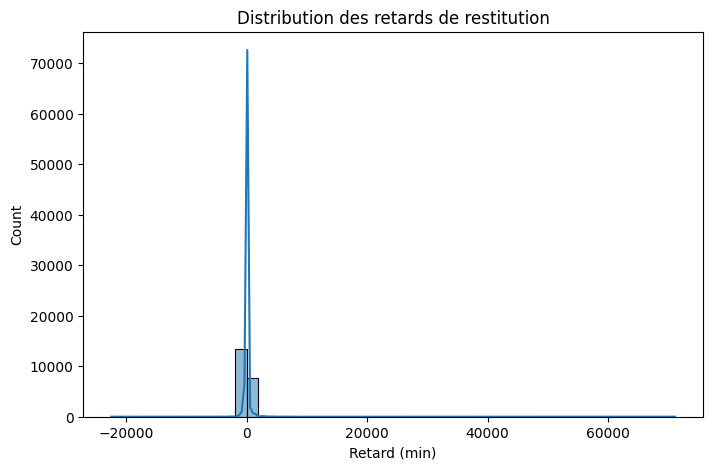

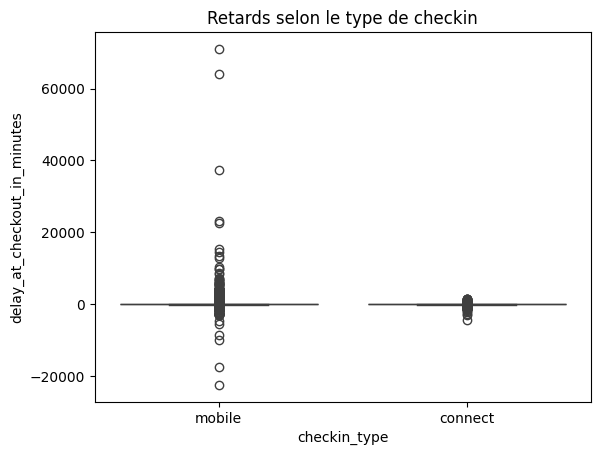

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(df['delay_at_checkout_in_minutes'], bins=50, kde=True)
plt.title("Distribution des retards de restitution")
plt.xlabel("Retard (min)")
plt.show()

sns.boxplot(data=df, x='checkin_type', y='delay_at_checkout_in_minutes')
plt.title("Retards selon le type de checkin")
plt.show()

In [8]:
thresholds = [30, 60, 90, 120, 180, 240]
conflicts = []

for t in thresholds:
    df['conflict'] = df['time_delta_with_previous_rental_in_minutes'] < t
    total_conflicts = df['conflict'].sum()
    total = len(df)
    conflicts.append({"threshold": t, "conflicting_rentals": total_conflicts, "percentage": round(total_conflicts / total * 100, 2)})

pd.DataFrame(conflicts)

,threshold,conflicting_rentals,percentage
0,30,279,1.31
1,60,401,1.88
2,90,584,2.74
3,120,666,3.13
4,180,870,4.08
5,240,1001,4.70


## Machine Learning - Optimisation des prix

In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [43]:
data = pd.read_csv('get_around_pricing_project.csv')

### Exploration des données

In [48]:
data.shape

(4843, 15)

In [49]:
data.columns

Index(['Unnamed: 0', 'model_key', 'mileage', 'engine_power', 'fuel',
       'paint_color', 'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires', 'rental_price_per_day'],
      dtype='object')

In [50]:
data.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [52]:
data.isnull().sum()

Unnamed: 0                   0
model_key                    0
mileage                      0
engine_power                 0
fuel                         0
paint_color                  0
car_type                     0
private_parking_available    0
has_gps                      0
has_air_conditioning         0
automatic_car                0
has_getaround_connect        0
has_speed_regulator          0
winter_tires                 0
rental_price_per_day         0
dtype: int64

In [53]:
data['rental_price_per_day'].describe()

count    4843.000000
mean      121.214536
std        33.568268
min        10.000000
25%       104.000000
50%       119.000000
75%       136.000000
max       422.000000
Name: rental_price_per_day, dtype: float64

### Preprocessing

In [54]:
X = data.drop(columns=['rental_price_per_day'])
y = data['rental_price_per_day']

In [55]:
if 'Unnamed: 0' in X.columns:
    X = X.drop(columns=['Unnamed: 0'])

In [56]:
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
print(f"Colonnes catégorielles à encoder: {categorical_columns}")

Colonnes catégorielles à encoder: ['model_key', 'fuel', 'paint_color', 'car_type']


In [57]:
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [58]:
print(f"Shape après encodage: {X_encoded.shape}")
print(f"Colonnes object restantes: {X_encoded.select_dtypes(include=['object']).columns.tolist()}")

Shape après encodage: (4843, 55)
Colonnes object restantes: []


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Taille du dataset d'entraînement: {X_train.shape}")
print(f"Taille du dataset de test: {X_test.shape}")

Taille du dataset d'entraînement: (3874, 55)
Taille du dataset de test: (969, 55)


### Entraînement des modèles 

In [ ]:
# Dictionnaire pour stocker les résultats
models_results = {}

# LINEAR REGRESSION
print("\n📈 Linear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)

models_results['Linear Regression'] = {
    'model': lr_model,
    'r2': lr_r2,
    'rmse': lr_rmse,
    'mae': lr_mae
}

print(f"  R²: {lr_r2:.4f}")
print(f"  RMSE: {lr_rmse:.2f}€")
print(f"  MAE: {lr_mae:.2f}€")


📈 Linear Regression
  R²: 0.6937
  RMSE: 17.96€
  MAE: 12.12€


In [61]:
# RANDOM FOREST (Simple)
print("\n🌳 Random Forest (Simple)")
rf_simple = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_simple.fit(X_train, y_train)

y_pred_rf_simple = rf_simple.predict(X_test)
rf_simple_r2 = r2_score(y_test, y_pred_rf_simple)
rf_simple_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_simple))
rf_simple_mae = mean_absolute_error(y_test, y_pred_rf_simple)

models_results['Random Forest (Simple)'] = {
    'model': rf_simple,
    'r2': rf_simple_r2,
    'rmse': rf_simple_rmse,
    'mae': rf_simple_mae
}

print(f"  R²: {rf_simple_r2:.4f}")
print(f"  RMSE: {rf_simple_rmse:.2f}€")
print(f"  MAE: {rf_simple_mae:.2f}€")


🌳 Random Forest (Simple)
  R²: 0.7315
  RMSE: 16.82€
  MAE: 10.71€


In [63]:
# RANDOM FOREST (Optimisé)
print("\n🔍 Random Forest (Optimisation des hyperparamètres)")

# Grille de paramètres plus légère pour éviter la surcharge
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_grid, 
    param_grid, 
    cv=3,  # Réduit pour accélérer
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
rf_optimized = grid_search.best_estimator_

y_pred_rf_opt = rf_optimized.predict(X_test)
rf_opt_r2 = r2_score(y_test, y_pred_rf_opt)
rf_opt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
rf_opt_mae = mean_absolute_error(y_test, y_pred_rf_opt)

models_results['Random Forest (Optimized)'] = {
    'model': rf_optimized,
    'r2': rf_opt_r2,
    'rmse': rf_opt_rmse,
    'mae': rf_opt_mae
}

print(f"  Meilleurs paramètres: {grid_search.best_params_}")
print(f"  R²: {rf_opt_r2:.4f}")
print(f"  RMSE: {rf_opt_rmse:.2f}€")
print(f"  MAE: {rf_opt_mae:.2f}€")


🔍 Random Forest (Optimisation des hyperparamètres)
  Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
  R²: 0.7333
  RMSE: 16.76€
  MAE: 10.66€


### Comparaison des modèles

In [64]:
# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Model': models_results.keys(),
    'R²': [models_results[model]['r2'] for model in models_results.keys()],
    'RMSE': [models_results[model]['rmse'] for model in models_results.keys()],
    'MAE': [models_results[model]['mae'] for model in models_results.keys()]
})

print(comparison_df.round(4))

                       Model      R²     RMSE      MAE
0          Linear Regression  0.6937  17.9605  12.1153
1     Random Forest (Simple)  0.7315  16.8161  10.7101
2  Random Forest (Optimized)  0.7333  16.7604  10.6572


In [65]:
# Sélectionner le meilleur modèle
best_model_name = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_model = models_results[best_model_name]['model']

print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   R²: {models_results[best_model_name]['r2']:.4f}")
print(f"   RMSE: {models_results[best_model_name]['rmse']:.2f}€")
print(f"   MAE: {models_results[best_model_name]['mae']:.2f}€")


🏆 Meilleur modèle: Random Forest (Optimized)
   R²: 0.7333
   RMSE: 16.76€
   MAE: 10.66€


### Analyse des features importantes

In [66]:
if 'Random Forest' in best_model_name:
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 des variables les plus importantes:")
    print(feature_importance.head(10))

Top 10 des variables les plus importantes:
                  feature  importance
1            engine_power    0.446977
0                 mileage    0.280883
3                 has_gps    0.041901
6   has_getaround_connect    0.028523
53           car_type_suv    0.019151
38            fuel_petrol    0.014231
10          model_key_BMW    0.012803
11      model_key_Citroën    0.011972
23   model_key_Mitsubishi    0.011429
5           automatic_car    0.010796


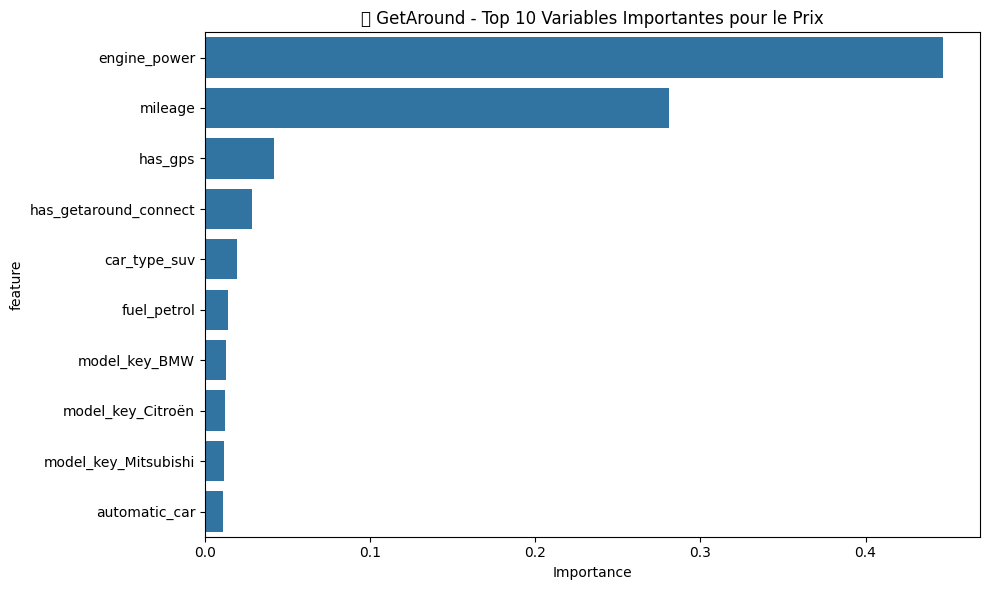

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('🚗 GetAround - Top 10 Variables Importantes pour le Prix')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Visualisation

In [70]:
# Prédictions vs Réalité
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0.5, 1.0, 'Random Forest (Optimized)\n(R² = 0.733)')

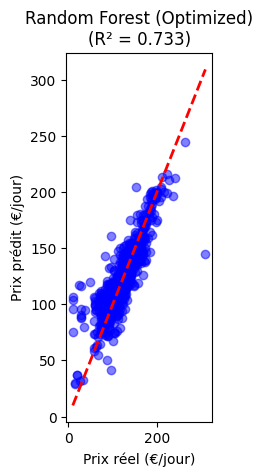

In [71]:
# Subplot 1: Meilleur modèle
plt.subplot(1, 3, 1)
best_pred = best_model.predict(X_test)
plt.scatter(y_test, best_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Prix réel (€/jour)')
plt.ylabel('Prix prédit (€/jour)')
plt.title(f'{best_model_name}\n(R² = {models_results[best_model_name]["r2"]:.3f})')

Text(0.5, 1.0, 'Analyse des Résidus')

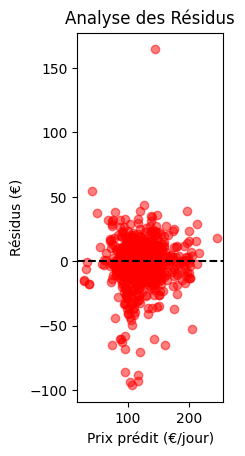

In [72]:
# Subplot 2: Résidus
plt.subplot(1, 3, 2)
residuals = y_test - best_pred
plt.scatter(best_pred, residuals, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Prix prédit (€/jour)')
plt.ylabel('Résidus (€)')
plt.title('Analyse des Résidus')

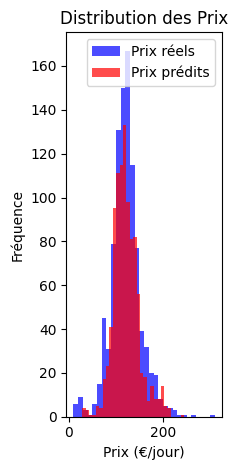

In [73]:
# Subplot 3: Distribution des prix
plt.subplot(1, 3, 3)
plt.hist(y_test, bins=30, alpha=0.7, label='Prix réels', color='blue')
plt.hist(best_pred, bins=30, alpha=0.7, label='Prix prédits', color='red')
plt.xlabel('Prix (€/jour)')
plt.ylabel('Fréquence')
plt.title('Distribution des Prix')
plt.legend()

plt.tight_layout()
plt.show()

### Sauvegarde du modèle pour l'API

In [74]:
model_data = {
    'model': best_model,
    'model_name': best_model_name,
    'feature_names': X_encoded.columns.tolist(),
    'categorical_columns': categorical_columns,
    'metrics': {
        'r2': models_results[best_model_name]['r2'],
        'rmse': models_results[best_model_name]['rmse'],
        'mae': models_results[best_model_name]['mae']
    }
}

In [75]:
# Sauvegarder avec joblib
joblib.dump(model_data, 'getaround_pricing_model.pkl')
print("✅ Modèle sauvegardé dans 'getaround_pricing_model.pkl'")

✅ Modèle sauvegardé dans 'getaround_pricing_model.pkl'


### Fonction de prédiction

In [76]:
def predict_rental_price(model_data, input_features):
    """
    Fonction pour prédire le prix d'une location GetAround
    
    Args:
        model_data: dictionnaire avec le modèle et les métadonnées
        input_features: dictionnaire avec les caractéristiques de la voiture
    
    Returns:
        prix prédit en €/jour
    """
    # Créer un DataFrame avec les features d'entrée
    input_df = pd.DataFrame([input_features])
    
    # Appliquer le même preprocessing
    input_df_encoded = pd.get_dummies(
        input_df, 
        columns=model_data['categorical_columns'], 
        drop_first=True
    )
    
    # Réaligner avec les colonnes du modèle
    for col in model_data['feature_names']:
        if col not in input_df_encoded.columns:
            input_df_encoded[col] = 0
    
    # Réorganiser les colonnes dans le bon ordre
    input_df_encoded = input_df_encoded[model_data['feature_names']]
    
    # Prédiction
    prediction = model_data['model'].predict(input_df_encoded)[0]
    
    return round(prediction, 2)

#### Exemple de prédiction

In [77]:
# Charger le modèle sauvegardé
loaded_model_data = joblib.load('getaround_pricing_model.pkl')

# Exemple de voiture à prédire
example_car = {
    'model_key': 'Citroën',
    'mileage': 50000,
    'engine_power': 120,
    'fuel': 'diesel',
    'paint_color': 'black',
    'car_type': 'convertible',
    'private_parking_available': True,
    'has_gps': True,
    'has_air_conditioning': True,
    'automatic_car': False,
    'has_getaround_connect': True,
    'has_speed_regulator': True,
    'winter_tires': False
}

try:
    predicted_price = predict_rental_price(loaded_model_data, example_car)
    print(f"Prix prédit pour cette voiture: {predicted_price}€/jour")
except Exception as e:
    print(f"Erreur lors de la prédiction: {e}")

Prix prédit pour cette voiture: 150.74€/jour


In [78]:
# 9. RÉSUMÉ FINAL
print("\n" + "=" * 60)
print("🎯 RÉSUMÉ FINAL - GETAROUND PRICING MODEL")
print("=" * 60)
print(f"📊 Dataset: {data.shape[0]} voitures, {data.shape[1]} variables")
print(f"🤖 Meilleur modèle: {best_model_name}")
print(f"📈 Performance:")
print(f"   • R²: {models_results[best_model_name]['r2']:.4f}")
print(f"   • RMSE: {models_results[best_model_name]['rmse']:.2f}€")
print(f"   • MAE: {models_results[best_model_name]['mae']:.2f}€")
print(f"💾 Modèle sauvegardé: getaround_pricing_model.pkl")
print(f"🔌 Prêt pour l'API Flask/FastAPI")
print("=" * 60)


🎯 RÉSUMÉ FINAL - GETAROUND PRICING MODEL
📊 Dataset: 4843 voitures, 15 variables
🤖 Meilleur modèle: Random Forest (Optimized)
📈 Performance:
   • R²: 0.7333
   • RMSE: 16.76€
   • MAE: 10.66€
💾 Modèle sauvegardé: getaround_pricing_model.pkl
🔌 Prêt pour l'API Flask/FastAPI
